In [155]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn import metrics
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import skew
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score, r2_score, f1_score,\
roc_auc_score,mean_absolute_error,mean_absolute_percentage_error,max_error
import shap  # library for explaining model predictions

In [ ]:
# Load the prepared dataset
data_fin_imprt=pd.read_csv("final.csv",  delimiter=',')

In [157]:
data_fin_imprt.head(15)

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,3.044522,4.955827,10.366309,6,1.791759,7.581210,1960,4.727388,6.461468,0.000000,...,False,False,False,True,False,False,False,False,True,False
1,3.044522,4.394449,9.360741,5,1.945910,7.581720,1961,0.000000,6.150603,4.976734,...,False,False,False,True,False,False,False,False,True,False
2,3.044522,4.406719,9.565775,6,1.945910,7.580189,1958,4.691348,6.828712,0.000000,...,False,False,False,True,False,False,False,False,True,False
3,3.044522,4.543295,9.320181,7,1.791759,7.585281,1968,0.000000,6.971669,0.000000,...,False,False,False,True,False,False,False,False,True,False
4,4.110874,4.317488,9.534668,5,1.791759,7.599902,1998,0.000000,6.674561,0.000000,...,False,False,False,True,False,False,False,False,True,False
5,4.110874,4.369448,9.208238,6,1.945910,7.600402,1998,3.044522,6.401917,0.000000,...,False,False,False,True,False,False,False,False,True,False
6,4.795791,3.737670,8.501267,8,1.791759,7.601902,2001,0.000000,6.424869,0.000000,...,False,False,False,True,False,False,False,False,True,False
7,4.795791,3.784190,8.518392,8,1.791759,7.597396,1992,0.000000,5.575949,0.000000,...,False,False,False,True,False,False,False,False,True,False
8,4.795791,3.688879,8.592301,8,1.791759,7.598900,1996,0.000000,7.074117,0.000000,...,False,False,False,True,False,False,False,False,True,False
9,4.110874,4.110874,8.922792,7,1.791759,7.600902,1999,0.000000,0.000000,0.000000,...,False,False,False,True,False,False,False,False,True,False


In [ ]:
# Split data into features and target, then create train/test split
x=data_fin_imprt.drop('SalePrice',axis=1)
y=data_fin_imprt['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Train the basic XGBoost model
xgb_mod = xgb.XGBRegressor()
xgb_mod.fit(x_train, y_train)
xgb_pred = xgb_mod.predict(x_test)

In [160]:
xgb_mod_sc=xgb_mod.score(x_train,y_train)
print('XGB Regression Model Score  : ',round(xgb_mod_sc,3))
r2=r2_score(y_test,xgb_pred)# computing and displaying the R.Sq of the model
print('R Sq. Value : ',round(r2,2))
rfr_adj_r2 = 1 - (1-r2) * (len(y)-1)/(len(y)-x.shape[1]-1)
print('Adjusted R Sq. Value is : ', round(rfr_adj_r2,3))
mean_sq=mean_squared_error(y_test,xgb_pred)# computing and displaying the Mean square error of the model
print('Mean Square Error is : ', round(mean_sq,3))
lin_rmse=mean_squared_error(y_test,xgb_pred,squared = False)
print('Root Mean Square Error is : ', round(lin_rmse,3))
lin_mae=mean_absolute_error(y_test, xgb_pred)
print('Mean Absoulue Error is : ', round(lin_mae,3))
scores_cvs = cross_val_score(xgb_mod, x, y,scoring='r2' ,cv=5) 
print("Accuracy :",round(scores_cvs.mean()*100,2),"%") # Accuracy of model

XGB Regression Model Score  :  0.998
R Sq. Value :  0.92
Adjusted R Sq. Value is :  0.907
Mean Square Error is :  0.016
Root Mean Square Error is :  0.125
Mean Absoulue Error is :  0.085
Accuracy : 88.75 %


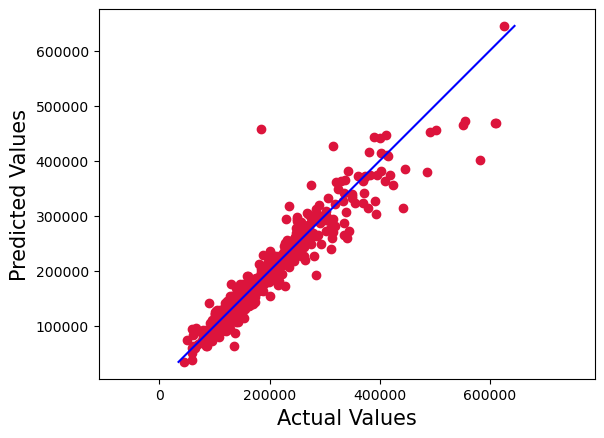

In [161]:
# Plot actual vs predicted prices (convert from log scale back to dollars)
Actual_Price=np.expm1(y_test)
Predicted_Price=np.expm1(xgb_pred)
plt.scatter(Actual_Price, Predicted_Price, c='crimson')
p1 = max(max(Predicted_Price), max(Actual_Price))
p2 = min(min(Predicted_Price), min(Actual_Price))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


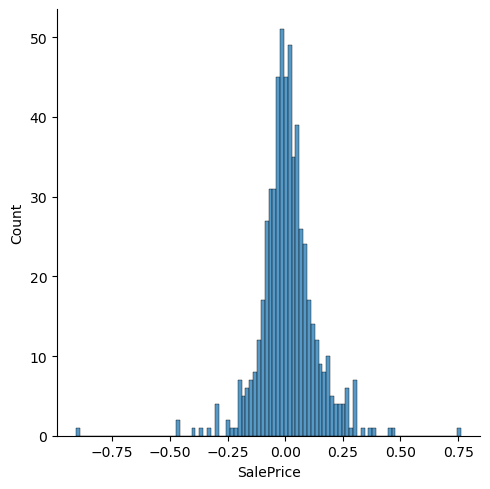

In [162]:
# Plot distribution of residuals
sb.displot((y_test-xgb_pred),bins=100); 

In [ ]:
# Define hyperparameters for grid search
params = {
        'objective' : ['reg:squarederror','reg:linear'],
        'min_child_weight': [1,2],
        'gamma': [0.5, 1],
        'subsample': [0.2, 0.4],
        'max_depth': [1, 2]
        }

In [164]:
# G_CV_lin_rid = GridSearchCV(estimator=xgb_mod, param_grid=params, cv= 5) 
# #  using grid search method to optimise model with hyperparameter tuning

# G_CV_lin_rid.fit(x_train, y_train)# fitting the model
# G_CV_lin_rid.best_params_ # displaying optimised parameters for optimal tuning of model

{'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6}

In [ ]:
# Retrain model with optimized hyperparameters
xgb_mod = xgb.XGBRegressor(objective="reg:squarederror", max_depth=10,gamma=0.001,min_child_weight=50,subsample=1)
xgb_mod.fit(x_train, y_train)
xgb_pred = xgb_mod.predict(x_test)

In [166]:
xgb_mod_sc=xgb_mod.score(x_train,y_train)
print('XGB Regression Model Score  : ',round(xgb_mod_sc,3))
r2=r2_score(y_test,xgb_pred)# computing and displaying the R.Sq of the model
print('R Sq. Value : ',round(r2,2))
rfr_adj_r2 = 1 - (1-r2) * (len(y)-1)/(len(y)-x.shape[1]-1)
print('Adjusted R Sq. Value is : ', round(rfr_adj_r2,3))
mean_sq=mean_squared_error(y_test,xgb_pred)# computing and displaying the Mean square error of the model
print('Mean Square Error is : ', round(mean_sq,3))
lin_rmse=mean_squared_error(y_test,xgb_pred,squared = False)
print('Root Mean Square Error is : ', round(lin_rmse,3))
lin_mae=mean_absolute_error(y_test, xgb_pred)
print('Mean Absoulue Error is : ', round(lin_mae,3))
scores_cvs = cross_val_score(xgb_mod, x, y,scoring='r2' ,cv=5)
print("Accuracy :",round(scores_cvs.mean()*100,2),"%")
# Accuracy of moadel based on parameter supplied by GridsearchCV

XGB Regression Model Score  :  0.984
R Sq. Value :  0.93
Adjusted R Sq. Value is :  0.924
Mean Square Error is :  0.013
Root Mean Square Error is :  0.112
Mean Absoulue Error is :  0.082
Accuracy : 89.47 %


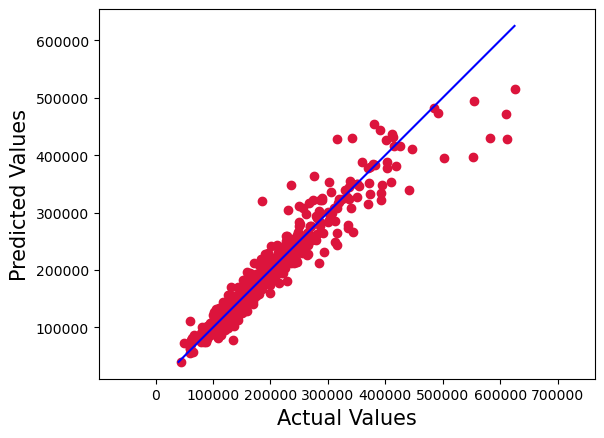

In [167]:
# Plot actual vs predicted prices (convert from log scale back to dollars)
Actual_Price=np.expm1(y_test)
Predicted_Price=np.expm1(xgb_pred)
plt.scatter(Actual_Price, Predicted_Price, c='crimson')
p1 = max(max(Predicted_Price), max(Actual_Price))
p2 = min(min(Predicted_Price), min(Actual_Price))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


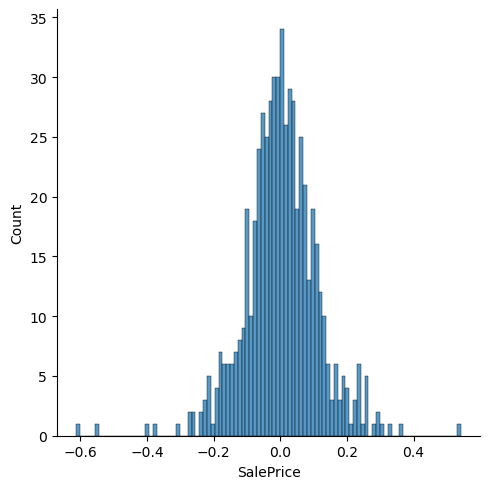

In [168]:
# Plot distribution of residuals
sb.displot((y_test-xgb_pred),bins=100); 

<Axes: >

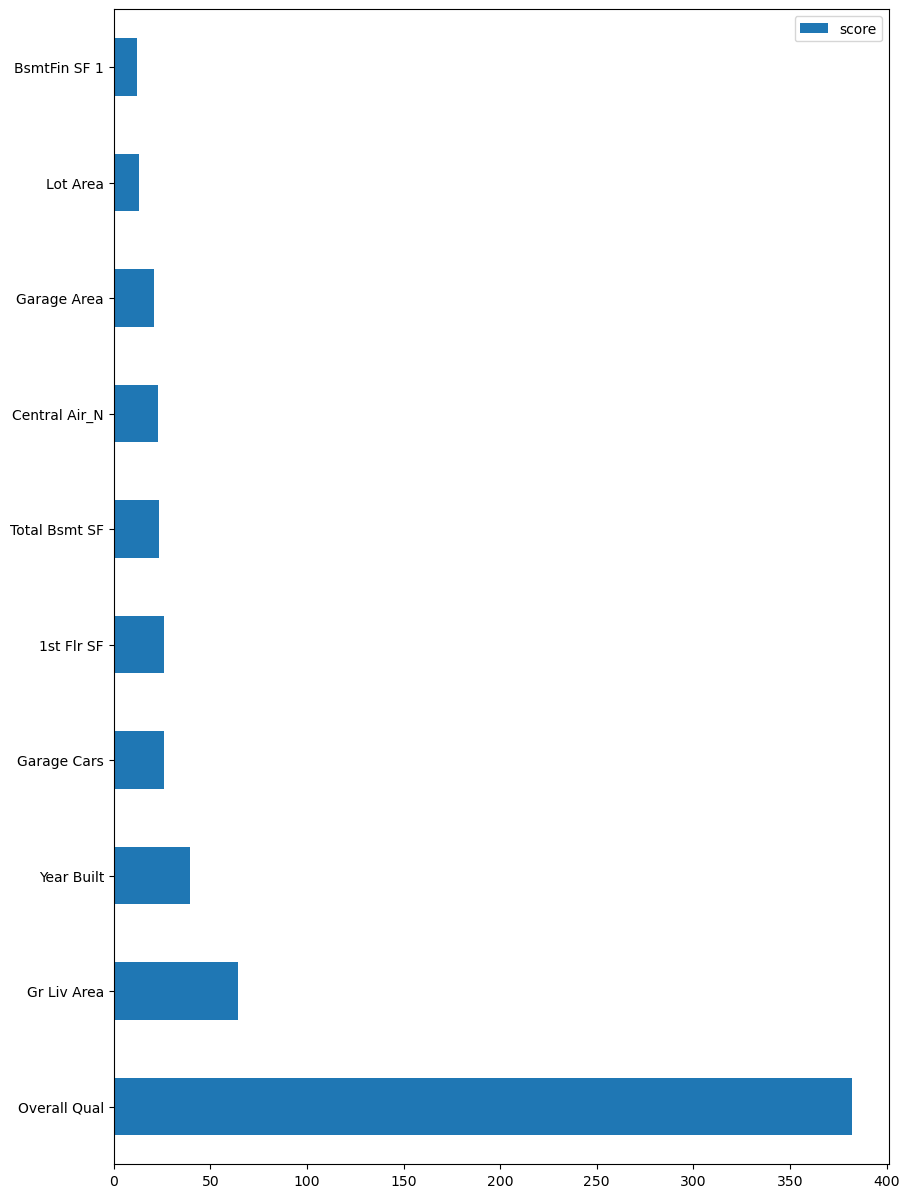

In [ ]:
# Plot top 10 most important features based on total gain
feature_important = xgb_mod.get_booster().get_score(importance_type='total_gain')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (10,15))

In [ ]:
# Function to calculate and visualize feature importance using SHAP
def explain_model(model, x_train, x_test):
    # Sample smaller amounts to avoid computation issues
    test_sample = x_test.sample(min(200, len(x_test)), random_state=42)
    background = x_train.sample(min(200, len(x_train)), random_state=42)
    
    # Convert to arrays with all features included, using original column order
    test_array = test_sample.values.astype(np.float32)
    background_array = background.values.astype(np.float32)
    
    # Check for infinities or NaNs and replace them
    test_array = np.nan_to_num(test_array, nan=0.0, posinf=0.0, neginf=0.0)
    background_array = np.nan_to_num(background_array, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Use shap.Explainer with model.predict to avoid TreeExplainer version issues
    def predict_wrapper(X):
        # Convert numpy array back to DataFrame with correct column names
        return model.predict(pd.DataFrame(X, columns=x_train.columns))
    
    explainer = shap.Explainer(predict_wrapper, background_array)
    shap_values = explainer(test_array)
    
    shap.summary_plot(shap_values.values, test_sample, plot_type="bar")
    return shap_values

PermutationExplainer explainer: 201it [00:11,  2.28it/s]                         
/var/folders/p7/hb0z_16573l2434bm7ym41cc0000gn/T/ipykernel_9233/398688421.py:25: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, test_sample, plot_type="bar")


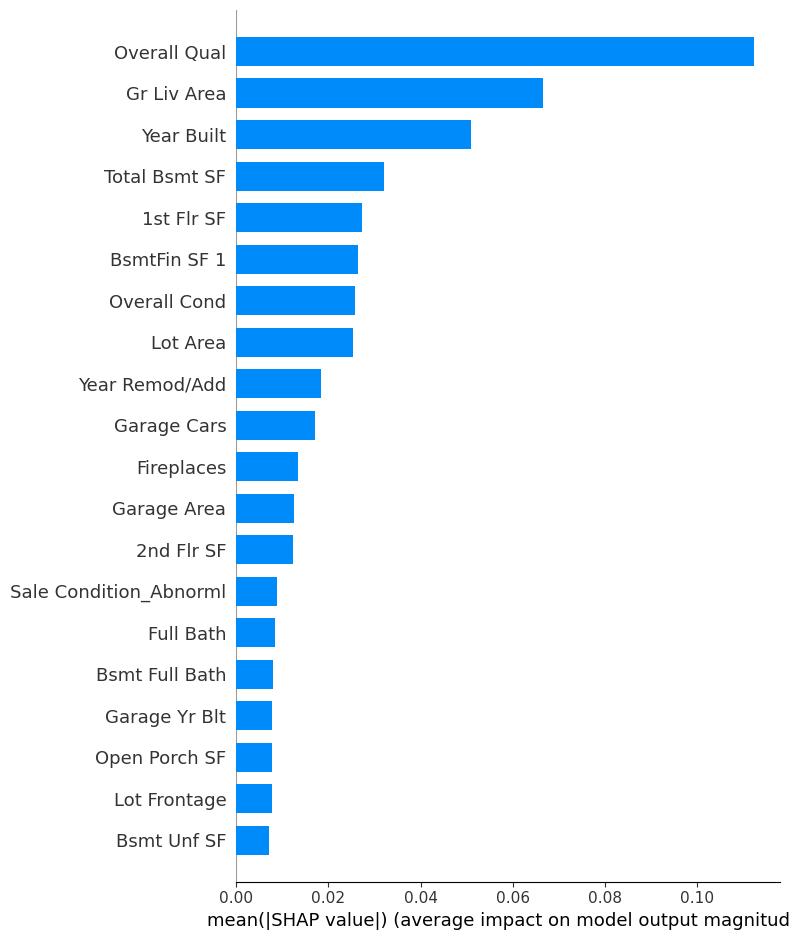

In [171]:
# Run SHAP analysis on the trained XGBoost model
shap_values = explain_model(xgb_mod, x_train, x_test)